# H₃⁺ Noise Scan — Noisy vs Noiseless VQE

This notebook compares **noisy and noiseless VQE** for the trihydrogen cation H₃⁺:

- Compute reference energies/states (noiseless, multiple seeds)
- Apply depolarizing / amplitude damping noise over a range of probabilities
- Compare:
  - Convergence curves
  - Energy error vs noise
  - Fidelity to noiseless reference
  - Optimizer comparison
  - Ansatz comparison

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt

import sys, os, json
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from vqe.vqe_utils import (
    excitation_ansatz,
    set_seed,
    get_optimizer,
    ensure_dirs,
    make_run_config_dict,
    run_signature,
    find_existing_run,
    save_run_record,
    build_run_filename,
    init_params,
    IMG_DIR,
    ANSATZES,
)

ensure_dirs()

In [2]:
# Molecule + configuration

seeds = np.arange(0, 3)

symbols = ["H", "H", "H"]
coordinates = np.array([
    [0.000000,  1.000000,  0.000000],
    [-0.866025, -0.500000, 0.000000],
    [ 0.866025, -0.500000, 0.000000]
])

basis = "STO-3G"
electrons = 2
optimizer_name = "Adam"
stepsize = 0.2
max_iterations = 50
ansatz_desc = "TwoQubit-RY-CNOT"

hamiltonian, qubits = qchem.molecular_hamiltonian(
    symbols, coordinates, charge=+1, basis=basis
)
hf = qchem.hf_state(electrons, qubits)

num_wires = qubits
singles, doubles = qchem.excitations(electrons, qubits)

noise_levels = np.arange(0, 0.11, 0.025)

In [3]:
# Build VQE QNodes (noisy or noiseless)

def get_vqe_qnode(ansatz_fn=None, noisy=True, return_state=False,
                  depolarizing_prob=0.0, amplitude_damping_prob=0.0):

    dev = qml.device("default.mixed" if noisy else "default.qubit",
                     wires=num_wires)
    diff_method = "finite-diff" if noisy else "parameter-shift"

    @qml.qnode(dev, diff_method=diff_method)
    def circuit(params):

        if ansatz_fn == excitation_ansatz:
            excitation_ansatz(
                params,
                wires=range(num_wires),
                hf_state=hf,
                excitations=(singles, doubles),
                excitation_type="both",
            )
        else:
            ansatz_fn(params, wires=range(num_wires))

        if noisy:
            for w in range(num_wires):
                qml.DepolarizingChannel(depolarizing_prob, wires=w)
                qml.AmplitudeDamping(amplitude_damping_prob, wires=w)

        return qml.state() if return_state else qml.expval(hamiltonian)

    return circuit

In [4]:
# Cache-aware VQE wrapper

def run_vqe_with_cache(
    seed,
    noisy=True,
    dep_prob=0.0,
    amp_prob=0.0,
    optimizer_name="Adam",
    ansatz_name=None,
):

    ansatz_fn = ANSATZES.get(ansatz_name, excitation_ansatz)
    set_seed(seed)

    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc=ansatz_name or ansatz_desc,
        optimizer_name=optimizer_name,
        stepsize=stepsize,
        max_iterations=max_iterations,
        seed=seed,
        noisy=noisy,
        depolarizing_prob=dep_prob,
        amplitude_damping_prob=amp_prob,
    )

    sig = run_signature(cfg)
    fname = build_run_filename("H3plus_Noise_Error", optimizer_name, seed, sig)
    existing = find_existing_run(sig)

    # --- Load existing ---
    if existing:
        with open(existing) as f:
            rec = json.load(f)
        energies = rec["energies"]
        params = np.array(rec["final_params"])
        final_state = (
            np.array(rec.get("final_state_real", []))
            + 1j * np.array(rec.get("final_state_imag", []))
        )
        return energies, params, final_state

    # --- Compute fresh ---
    if ansatz_name is None or ansatz_name not in ANSATZES:
        n_params = len(singles) + len(doubles)
        params = 0.01 * np.random.randn(n_params)
    else:
        params = init_params(ansatz_name, num_wires=num_wires, scale=0.01)

    cost_fn = get_vqe_qnode(
        ansatz_fn=ansatz_fn,
        noisy=noisy,
        return_state=False,
        depolarizing_prob=dep_prob,
        amplitude_damping_prob=amp_prob,
    )
    opt = get_optimizer(optimizer_name, stepsize=stepsize)

    energies = [cost_fn(params)]
    for _ in range(max_iterations):
        params, e_prev = opt.step_and_cost(cost_fn, params)
        energies.append(e_prev)

    # final state
    final_state = get_vqe_qnode(
        ansatz_fn=ansatz_fn,
        noisy=noisy,
        return_state=True,
        depolarizing_prob=dep_prob,
        amplitude_damping_prob=amp_prob,
    )(params)

    rec = {
        "config": cfg,
        "energies": np.asarray(energies).tolist(),
        "final_params": np.asarray(params).tolist(),
        "final_state_real": np.real(final_state).tolist(),
        "final_state_imag": np.imag(final_state).tolist(),
    }
    save_run_record(fname, rec)

    return energies, params, final_state

In [5]:
# Fidelity helper

def fidelity(pure_ket, state_or_rho):

    if state_or_rho.ndim == 1:
        return np.abs(np.vdot(pure_ket, state_or_rho)) ** 2

    return np.real(np.vdot(pure_ket, state_or_rho @ pure_ket))

In [6]:
# Noise statistics (energy error + fidelity)

def compute_noise_stats(
    noise_values,
    ansatz_name=None,
    dep_prob=0.0,
    amp_prob=0.0,
    optimizer_name="Adam",
):

    energy_means, energy_stds = [], []
    fidelity_means, fidelity_stds = [], []

    for p in noise_values:

        results = [
            run_vqe_with_cache(
                seed=s,
                ansatz_name=ansatz_name,
                noisy=True,
                dep_prob=(p if dep_prob > 0 else 0.0),
                amp_prob=(p if amp_prob > 0 else 0.0),
                optimizer_name=optimizer_name,
            )
            for s in seeds
        ]

        noisy_energies = [r[0][-1] for r in results]
        dE = np.array(noisy_energies) - reference_energy

        energy_means.append(np.mean(dE))
        energy_stds.append(np.std(dE))

        fid = [fidelity(pure_state, r[2]) for r in results]
        fidelity_means.append(np.mean(fid))
        fidelity_stds.append(np.std(fid))

    return energy_means, energy_stds, fidelity_means, fidelity_stds

In [7]:
# Reference noiseless states & energies

noiseless_results = [
    run_vqe_with_cache(s, noisy=False, optimizer_name=optimizer_name)
    for s in seeds
]

noiseless_energies = [r[0][-1] for r in noiseless_results]
noiseless_states = [r[2] for r in noiseless_results]

reference_energy = np.mean(noiseless_energies)
pure_state = noiseless_states[0]

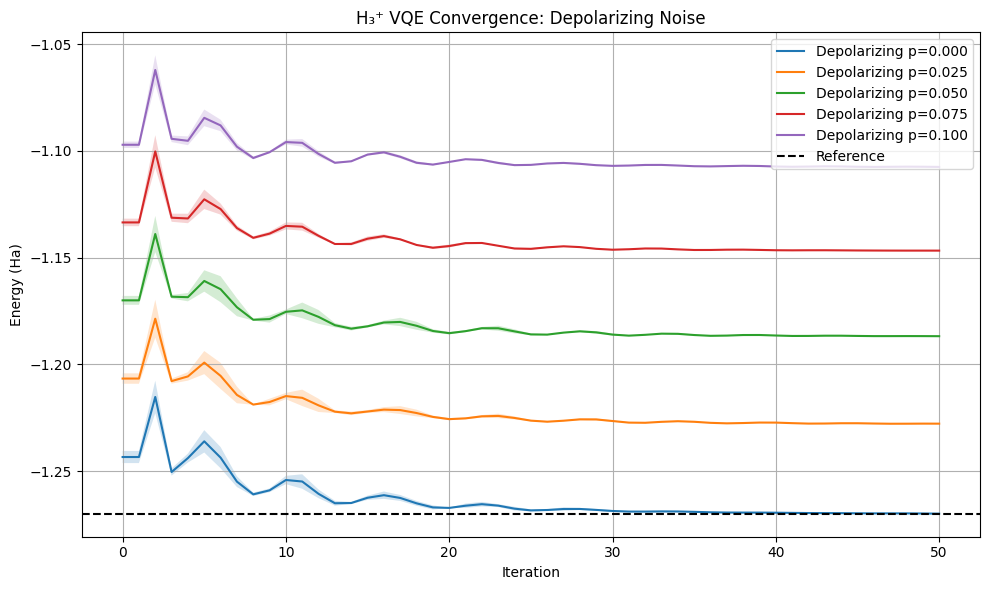

In [8]:
# Convergence curves under noise

plt.figure(figsize=(10, 6))
noise_type = "Depolarizing"

for p in noise_levels:

    all_energies = []
    for s in seeds:
        E, _, _ = run_vqe_with_cache(
            seed=s,
            noisy=True,
            dep_prob=(p if noise_type == "Depolarizing" else 0.0),
            amp_prob=(p if noise_type == "Amplitude" else 0.0),
            optimizer_name=optimizer_name,
        )
        all_energies.append(E)

    min_len = min(len(e) for e in all_energies)
    arr = np.array([e[:min_len] for e in all_energies])

    mean_energy = arr.mean(axis=0)
    std_energy = arr.std(axis=0)

    plt.fill_between(
        range(min_len),
        mean_energy - std_energy,
        mean_energy + std_energy,
        alpha=0.2,
    )
    plt.plot(range(min_len), mean_energy, label=f"{noise_type} p={p:.3f}")

plt.axhline(reference_energy, color="k", linestyle="--", label="Reference")
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title(f"H₃⁺ VQE Convergence: {noise_type} Noise")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H3plus_{noise_type}_Convergence.png", dpi=300)
plt.show()

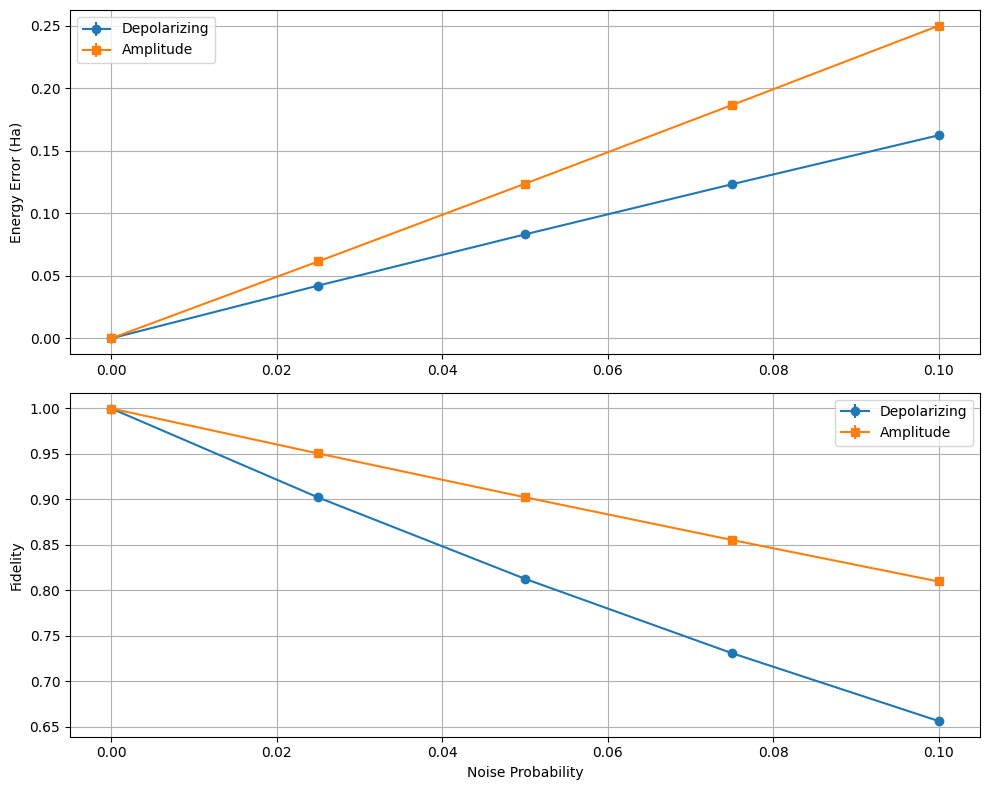

In [9]:
# Energy error + fidelity vs noise (two noise types)

energy_errors_dep, energy_stds_dep, fidelity_dep, fidelitystd_dep = compute_noise_stats(
    noise_levels, dep_prob=1, amp_prob=0
)

energy_errors_amp, energy_stds_amp, fidelity_amp, fidelitystd_amp = compute_noise_stats(
    noise_levels, dep_prob=0, amp_prob=1
)

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.errorbar(noise_levels, energy_errors_dep, yerr=energy_stds_dep, fmt="o-", label="Depolarizing")
plt.errorbar(noise_levels, energy_errors_amp, yerr=energy_stds_amp, fmt="s-", label="Amplitude")
plt.ylabel("Energy Error (Ha)")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.errorbar(noise_levels, fidelity_dep, yerr=fidelitystd_dep, fmt="o-", label="Depolarizing")
plt.errorbar(noise_levels, fidelity_amp, yerr=fidelitystd_amp, fmt="s-", label="Amplitude")
plt.xlabel("Noise Probability")
plt.ylabel("Fidelity")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H3plus_Noise_Error.png", dpi=300)
plt.show()

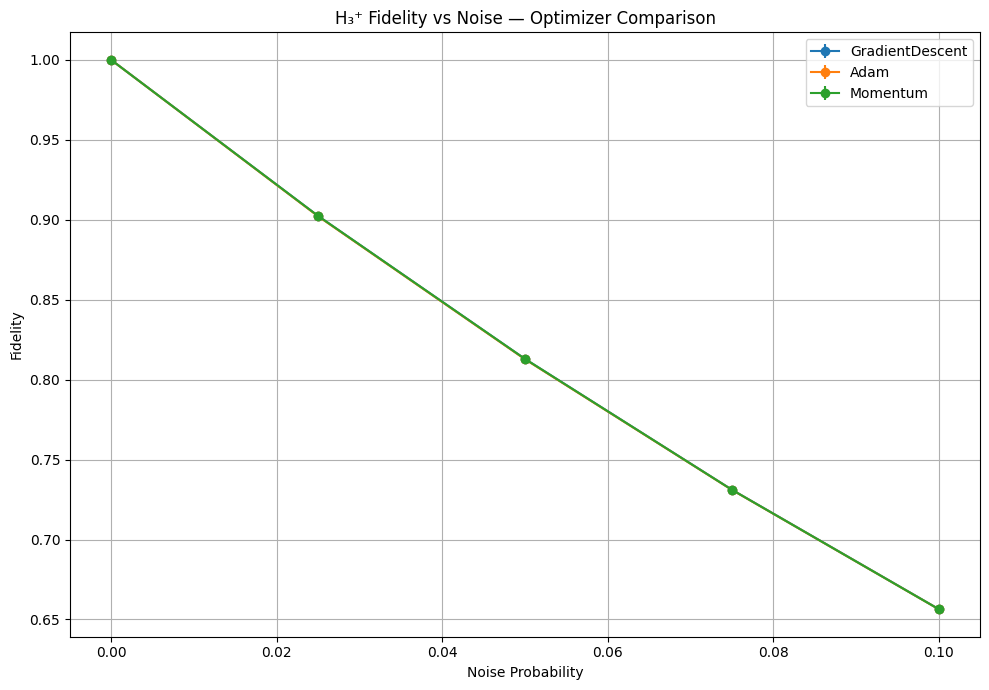

In [10]:
# Optimizer comparison (depolarizing only)

optimizers = ["GradientDescent", "Adam", "Momentum"]

plt.figure(figsize=(10, 7))
for opt_name in optimizers:
    _, _, fid_mean, fid_std = compute_noise_stats(
        noise_levels, dep_prob=1, amp_prob=0, optimizer_name=opt_name
    )
    plt.errorbar(noise_levels, fid_mean, yerr=fid_std, fmt="o-", label=opt_name)

plt.xlabel("Noise Probability")
plt.ylabel("Fidelity")
plt.title("H₃⁺ Fidelity vs Noise — Optimizer Comparison")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H3plus_Noise_Optimizers.png", dpi=300)
plt.show()

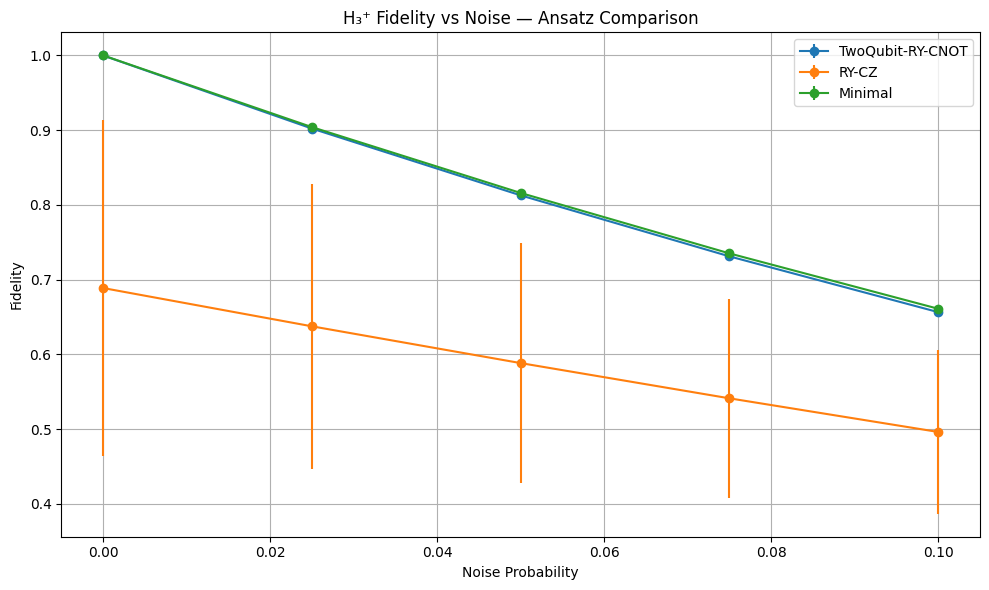

In [11]:
# Ansatz comparison (depolarizing only)

plt.figure(figsize=(10, 6))

for ansatz_name in ANSATZES:

    noiseless_results = [
        run_vqe_with_cache(s, noisy=False, optimizer_name=optimizer_name, ansatz_name=ansatz_name)
        for s in seeds
    ]

    energies0 = [r[0][-1] for r in noiseless_results]
    states0 = [r[2] for r in noiseless_results]

    reference_energy = np.mean(energies0)
    pure_state = states0[0]

    _, _, fid_mean, fid_std = compute_noise_stats(
        noise_levels,
        ansatz_name=ansatz_name,
        dep_prob=1,
        amp_prob=0,
        optimizer_name=optimizer_name,
    )

    plt.errorbar(noise_levels, fid_mean, yerr=fid_std, fmt="o-", label=ansatz_name)

plt.xlabel("Noise Probability")
plt.ylabel("Fidelity")
plt.title("H₃⁺ Fidelity vs Noise — Ansatz Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H3plus_Noise_Ansatzes.png", dpi=300)
plt.show()